In [24]:
import numpy as np
from numpy import pi as pi
import matplotlib.pyplot as plt
import qutip as q
import onix.models.hyperfine as hyperfine

%matplotlib ipympl

<h2>Lindblad Master Equation</h2>

tttttttttttt

$ \dot{\rho} = -i[H,\rho] + \sum_i C_i\rho C_i^\dagger - \frac{1}{2}\{C_i^\dagger C_i,\rho\}$

tttttttttttttttttt

$H(t) = H_0(t) + H_{\mathrm{lm,opt}}(t) + H_{\mathrm{lm,rf}}(t)$

In [223]:
class Simulation:
    """N level simulation.

    Args:
        states_g: the ground states used in the simulation. Default: all 6 states.
        states_e: the excited states used in the simulation. Default: all 6 states. Use [] for none.
        B_field: the static magnetic field in units of Gauss.
        sequence: a sequence list in the form of [(pulse1, ...), (pulse2, ...), ....] using:
            OPTICAL PULSES ("optical"  , transition     , duration (us))
            RF PULSES      ("rf"       , offset (MHz)   , duration (us))
            DELAY          ("delay"    , duration (us)                 )

    """
    def __init__(
        self, 
        states_g: list = ["a", "a'", "b", "b'", "c", "c'"], 
        states_e: list = ["a", "a'", "b", "b'", "c", "c'"],
        B_field: float = 200e-4,
        sequence: list = [],
    ):
        self._order_g = ["a'", "a", "b'", "b", "c'", "c"]
        self._order_e = ["c'", "c", "b'", "b", "a'", "a"]

        # Check input states
        for state in states_g + states_e:
            if state not in self._order_g:
                raise ValueError("Invalid input state.")

        # Check empty sequence
        if not sequence:
            raise ValueError("Empty sequence.")
            
        # Input states
        self._states_g = states_g
        self._states_e = states_e

        # Static B field
        self.B_field = B_field
        
        # Total number of states
        self._N = len(set(states_g)) + len(set(states_e))

        # Basis
        self.basis = self._set_basis()

        # Energies
        self.energies = self._set_energies()

        # Sequence
        self.sequence = sequence
        
    def _set_basis(self):
        """Returns the basis of the N levels used as an ordered dictionary using the global order.
        """
        basis = {}
        c = 0
        for term, term_list, order_list in zip(["7F0", "5D0"], [self._states_g, self._states_e], [self._order_g, self._order_e]):
            if term_list:
                basis[term] = {}
            for state in order_list:
                if state in term_list:
                    basis[term][state] = q.basis(self._N, c)
                    c += 1
        return basis

    def _set_energies(self):        
        """Returns the energies of the N levels used as an ordered dictionary using the global order.
        """
        energies = {}
        for term, term_list, order_list in zip(["7F0", "5D0"], [self._states_g, self._states_e], [self._order_g, self._order_e]):
            if term_list:
                energies[term] = {}
                term_hyperfine = hyperfine.states[term]
                term_hyperfine._Hamiltonian = term_hyperfine.H_total(self.B_field)
                energies_list, _ = term_hyperfine.energies_and_eigenstates()
                for ss, state in enumerate(order_list):
                    if state in term_list:
                        energies[term][state] = energies_list[ss]
        return energies

    def _set_detuning(self, detuning):
        """Sets the detuning of the excited states for the rotating way approximation (RWA).

        Args:
            detuning: in units of MHz.
        """
        if self._states_e:
            for state, _ in self.energies["5D0"].items():
                self.energies["5D0"][state] += -detuning

    def _get_H_0(self):
        """Sets the non-interacting Hamiltonian using the energies.
        """
        return q.Qobj(np.diag([2 * pi * self.energies[term][state] for term, states in self.energies.items() for state, _ in states.items()]))

    def _get_H_opt(self):
        """Sets the optical interaction Hamiltonian.
        """
        Omega_opt = 0.2 # MHz
        H_opt = q.Qobj(np.zeros((self._N, self._N)))
        if self._states_e:
            for state_g in self.basis["7F0"]:
                for state_e in self.basis["5D0"]:
                    H_i = self.basis["7F0"][state_g] * self.basis["5D0"][state_e].dag() + self.basis["5D0"][state_e] * self.basis["7F0"][state_g].dag()
                    H_opt += 2 * pi * Omega_opt / 2 * H_i
        return H_opt

    def _get_H_rf(self):
        """Sets the RF interaction Hamiltonian. No RWA used for RF transitions.

        Rabi frequencies defined inside.
        """
        N_g = len(set(self._states_g))
        H_rf = q.Qobj(np.zeros((self._N, self._N)))

        # RF Rabi frequency table
        # Rabi frequency in MHz
        rf_rabi_freqs = { 
            "a" : {
                "b" : 12.554634563e-3,
                "b'": 6.334254352e-3,
                "c" : 0,
                "c'": 0,
            },
            "a'": {
                "b" : 6.2756475647e-3,
                "b'": 12.612342565879e-3,
                "c" : 0,
                "c'": 0,
            },
            "b" : {
                "c" : 0,
                "c'": 0,
            },
            "b'": {
                "c" : 0,
                "c'": 0,   
            }
        }
        for state_1 in self.basis["7F0"]:
                for state_2 in self.basis["7F0"]:
                    if state_1 in rf_rabi_freqs.keys() and state_2 in rf_rabi_freqs[state_1].keys():
                        H_i = self.basis["7F0"][state_1] * self.basis["7F0"][state_2].dag() + self.basis["7F0"][state_2] * self.basis["7F0"][state_1].dag()
                        H_rf += 2 * pi * rf_rabi_freqs[state_1][state_2] * H_i
        return H_rf

    def _get_c_ops(self, gamma):
        """ Gets the collapse operators. (Currently only for spontaneous emission).

        Note: uses collapse operators as defined by QuTiP: C = sqrt(gamma) * A where A is the typical jump operator.

        Args:
            gamma: the rate of spontaneous emission.
        
        TODO: include unique gammas for each transition.
        TODO: include dephasing collapse operators.
        """
        c_ops = []
        N_g = len(set(self._states_g))
        gammas = {
            # TODO: include unique gammas for each transition
        }
        if self._states_e:
            print("test")
            sum_basis_g = 0
            for state in self.basis["7F0"]:
                sum_basis_g += self.basis["7F0"][state]
            for state in self.basis["5D0"]:
                c_ops.append(np.sqrt(gamma / N_g) * sum_basis_g * self.basis["5D0"][state].dag())
        return c_ops

    def _get_rho0(self):
        """Sets the initial conditions of the populations.

        TODO: use args.
        """
        N_g = len(set(self._states_g))
        sum_basis_g = 0
        for state in self.basis["7F0"]:
            sum_basis_g += self.basis["7F0"][state]
        return sum_basis_g / np.sqrt(N_g)

        # return (self.basis["7F0"]["b"] + self.basis["7F0"]["b'"]) / np.sqrt(2)
        
    def _rectangular_pulse(self, x, duration, start_time):
        """Simple rectangular pulse.

        Args:
            x: input parameter (i.e. time) (us)
            duration: total duration of pulse (us)
            start_time: start time of pulse (us)
        """
        start = start_time
        end = start_time + duration
        if x >= start and x < end:
            return 1
        else:
            return 0
        
    def _pulse(self, pulse_type, transition = "", offset = 0, duration = 0, start_time = 0):   
        """Setup pulse Hamiltonian.

            Args:
                pulse_type: the type of pulse: "optical", "rf", "delay"
                transition: used for optical pulses, e.g. "ab"
                offset: used for rf pulses, e.g. 0.2 (in MHz)
                duration: duration of pulse
                start_time: start time of pulse

            Returns the Hamiltonian for the pulse interval.
        """
        if pulse_type == "optical":
            state_g = transition[0]
            state_e = transition[1]
        
            average_energy_g = (self.energies["7F0"][state_g] + self.energies["7F0"][state_g + "'"]) / 2
            average_energy_e = (self.energies["5D0"][state_e] + self.energies["5D0"][state_e + "'"]) / 2

            omega = abs(average_energy_e - average_energy_g)
            self._set_detuning(omega)
            H_0 = self._get_H_0()
            self._set_detuning(-omega) # reset
            H_opt = self._get_H_opt()

            return [H_0 + H_opt, lambda t, args: self._rectangular_pulse(t, duration, start_time)]
            
        if pulse_type == "rf":
            omega = 2 * pi * (119.2 + offset) # MHz
            # self._set_detuning(3000)
            H_0 = self._get_H_0()
            # self._set_detuning(3000) # reset
            H_rf = self._get_H_rf()
            
            return [[H_0, lambda t, args: self._rectangular_pulse(t, duration, start_time)], [H_rf, lambda t, args: np.sin(omega * t) * self._rectangular_pulse(t, duration, start_time)]]   

        if pulse_type == "delay":
            H_0 = self._get_H_0()

            return [H_0, lambda t, args: self._rectangular_pulse(t, duration, start_time)]
            
    def run_sequence(self):
        """Uses the sequence to build the total Hamiltonian
        """
        sequence = self.sequence
        H_total = []
        total_time = 0

        for seq in sequence:
            if seq[0] == "optical":
                H_total.append(self._pulse(seq[0], transition = seq[1], duration = seq[2], start_time = total_time))
                total_time += seq[2]
                
            if seq[0] == "rf":
                H_0, H_rf = self._pulse(seq[0], offset = seq[1], duration = seq[2], start_time = total_time)
                H_total.append(H_0)
                H_total.append(H_rf)
                total_time += seq[2]
                
            if seq[0] == "delay":
                H_0 = self._pulse(seq[0], duration = seq[1], start_time = total_time)
                H_total.append(H_0)
                total_time += seq[1]
                
        return H_total, total_time
        
    def plot_simulation(self):
        """Plot simulation for all states.
        
           TODO: plots for any input state config
        """
        fig, axs = plt.subplots(2, 6, figsize=(12, 6))
        for ii, (i, iv) in enumerate(self.basis.items()):
            for jj, (j, _) in enumerate(iv.items()):
                axs[ii, jj].plot(self.ts, self.results.expect[ii * 6 + jj], label = f"{i}, {j}", linewidth=2)
                axs[ii, jj].set_title(f"{i}, {j}")
                axs[ii, jj].set_ylim([-1e-2, 1 + 1e-2])
                axs[ii, jj].set_xlim([0, np.max(self.ts)])
                axs[ii, jj].set_yticklabels([])
                axs[ii, jj].set_xlabel("time (us)")

        plt.tight_layout()
        plt.show()

    def single_plot_simulation(self):
        """Plot simulation for all states in 1 plot.
        
           TODO: plots for any input state config
        """
        fig, ax = plt.subplots(figsize=(12, 6))
        linestyles = ["solid", "dotted"]
        for ii, (i, iv) in enumerate(self.basis.items()):
            for jj, (j, _) in enumerate(iv.items()):
                # TODO: use input state length
                ax.plot(self.ts, self.results.expect[ii * 6 + jj], label = f"{i}, {j}", linewidth = 2, linestyle = linestyles[ii])
                ax.set_ylim([-1e-2, 1 + 1e-2])
                ax.set_xlim([0, np.max(self.ts)])
                ax.set_xlabel("time (us)")
                ax.set_ylabel("population")

        plt.legend()
        plt.tight_layout()
        plt.show()
        
    def single_plot_simulation2(self):
        """Temp
        """
        fig, ax = plt.subplots(figsize=(12, 6))
        linestyles = ["solid", "dotted"]
        for ii, (i, iv) in enumerate(self.basis.items()):
            for jj, (j, _) in enumerate(iv.items()):
                # TODO: use input state length
                if ii == 0:
                    ax.plot(self.ts, self.results.expect[ii * 6 + jj], label = f"{i}, {j}", linewidth = 2, linestyle = linestyles[ii])
                    ax.set_ylim([-1e-2, 1 + 1e-2])
                    ax.set_xlim([0, np.max(self.ts)])
                    ax.set_xlabel("time (us)")
                    ax.set_ylabel("population")

        plt.legend()
        plt.tight_layout()
        plt.show()
        
    def run_simulation(self, iters: int = 1000):
        """Run the QuTiP simulation.

            TODO: fix to have any input state config
        """
        H_total, total_time = self.run_sequence()
        ts = np.linspace(0, total_time, iters)

        lifetime_s = 2e-3
        decay_rate = 1 / lifetime_s
        decay_rate_MHz = decay_rate / 1e6
        c_ops = self._get_c_ops(decay_rate_MHz)
        rho_0 = self._get_rho0()
        e_ops = [self.basis[i][j] * self.basis[i][j].dag() for i, iv in self.basis.items() for j, _ in iv.items()]
        opts = q.Options(nsteps = 2000000)

        self.e_ops = e_ops
        self.results = q.mesolve(H_total, rho_0, ts, e_ops = e_ops, progress_bar = True, options = opts)
        self.ts = ts

In [207]:
q.mesolve?

Signature:
q.mesolve(
    H,
    rho0,
    tlist,
    c_ops=None,
    e_ops=None,
    args=None,
    options=None,
    progress_bar=None,
    _safe_mode=True,
)
Docstring:
Master equation evolution of a density matrix for a given Hamiltonian and
set of collapse operators, or a Liouvillian.

Evolve the state vector or density matrix (`rho0`) using a given
Hamiltonian or Liouvillian (`H`) and an optional set of collapse operators
(`c_ops`), by integrating the set of ordinary differential equations
that define the system. In the absence of collapse operators the system is
evolved according to the unitary evolution of the Hamiltonian.

The output is either the state vector at arbitrary points in time
(`tlist`), or the expectation values of the supplied operators
(`e_ops`). If e_ops is a callback function, it is invoked for each
time in `tlist` with time and the state as arguments, and the function
does not use any return values.

If either `H` or the Qobj elements in `c_ops` are superopera

In [99]:
sequence = []

# OPTICAL PULSES ("optical"  , transition     , duration (us))
# RF PULSES      ("rf"       , offset (MHz)   , duration (us))
# DELAY          ("delay"    , duration (us)                 )

sequence.append(("optical", "bb", 1000))
for i in range(8):
    sequence.append(("optical", "ca", 1000))
    sequence.append(("optical", "ac", 1000))
    sequence.append(("rf", -0.0153, 200))

simulation = Simulation(sequence = sequence)
simulation.run_simulation()
simulation.plot_simulation()

capi_return is NULL
Call-back cb_f_in_zvode__user__routines failed.


KeyboardInterrupt: 

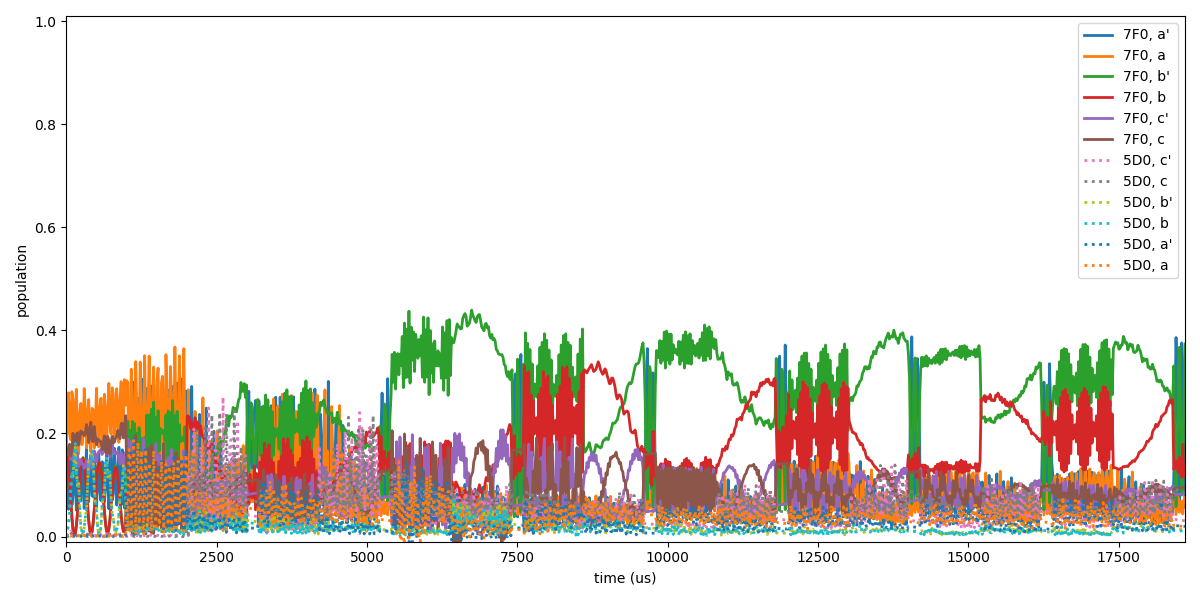

In [72]:
simulation.single_plot_simulation()

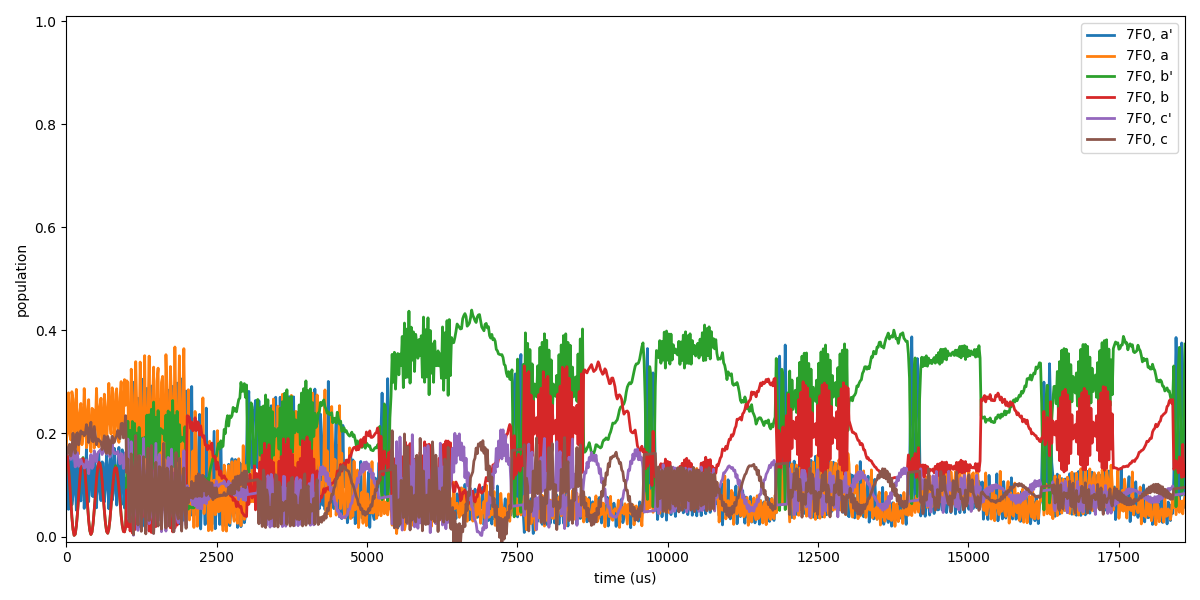

In [73]:
simulation.single_plot_simulation2()

In [18]:
simulation.energies["7F0"]["b'"] - simulation.energies["7F0"]["a'"] - 119.2

-0.015314509591974002

In [19]:
simulation.energies["7F0"]["b"] - simulation.energies["7F0"]["a'"] - 119.2

0.11098459520555082

In [20]:
simulation.energies["7F0"]["b'"] - simulation.energies["7F0"]["a"] - 119.2

-0.2428660957079103

In [21]:
simulation.energies["7F0"]["b"] - simulation.energies["7F0"]["a"] - 119.2

-0.11656699091038547

10.0%. Run time:  40.33s. Est. time left: 00:00:06:02
20.0%. Run time:  74.28s. Est. time left: 00:00:04:57
30.0%. Run time: 112.34s. Est. time left: 00:00:04:22
40.0%. Run time: 146.98s. Est. time left: 00:00:03:40
50.0%. Run time: 181.58s. Est. time left: 00:00:03:01
60.0%. Run time: 214.97s. Est. time left: 00:00:02:23
70.0%. Run time: 245.71s. Est. time left: 00:00:01:45
80.0%. Run time: 276.76s. Est. time left: 00:00:01:09
90.0%. Run time: 307.33s. Est. time left: 00:00:00:34
Total run time: 337.88s


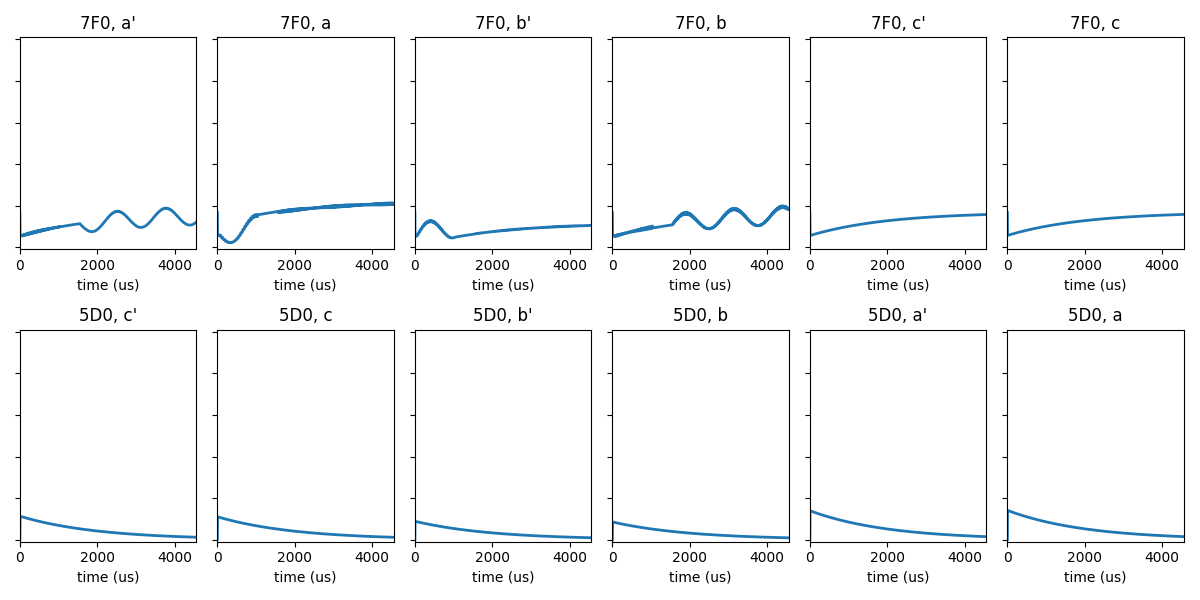

In [82]:
sequence = []

# OPTICAL PULSES ("optical"  , transition     , duration (us))
# RF PULSES      ("rf"       , offset (MHz)   , duration (us))
# DELAY          ("delay"    , duration (us)                 )

sequence.append(("optical", "bb", 1))
sequence.append(("optical", "ac", 1))
sequence.append(("optical", "ca", 1))
sequence.append(("delay", 50))
sequence.append(("rf", -0.242, 1000))
sequence.append(("delay", 500))
sequence.append(("rf", 0.1109, 3000))

simulation = Simulation(sequence = sequence)
simulation.run_simulation()
simulation.plot_simulation()

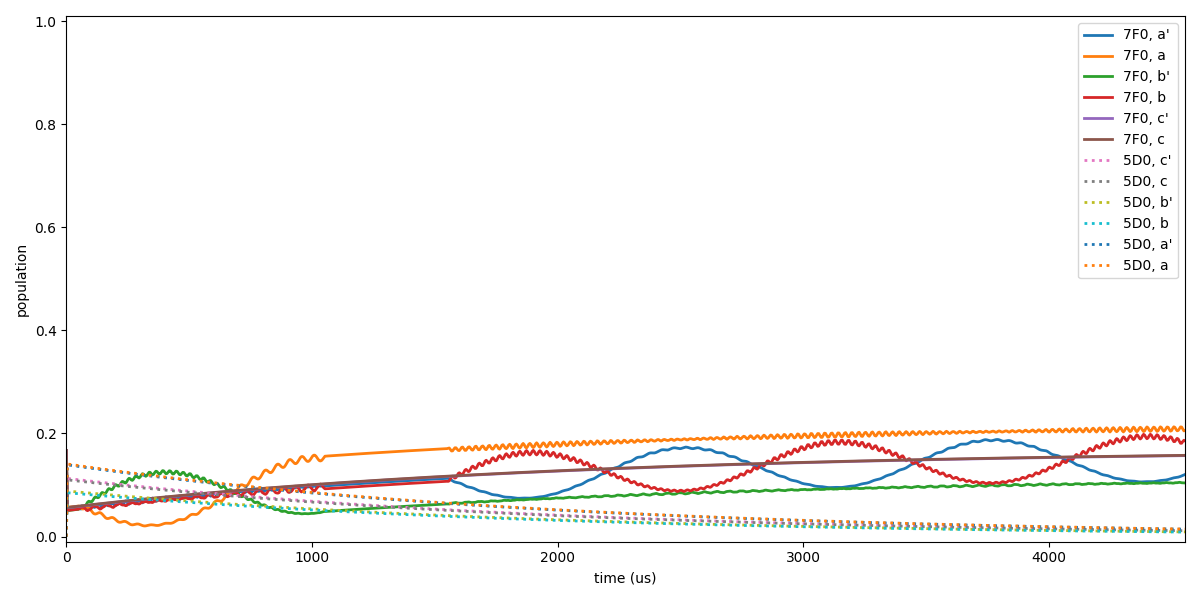

In [83]:
simulation.single_plot_simulation()

10.0%. Run time:   8.57s. Est. time left: 00:00:01:17
20.0%. Run time:  18.28s. Est. time left: 00:00:01:13
30.0%. Run time:  28.24s. Est. time left: 00:00:01:05
40.0%. Run time:  38.39s. Est. time left: 00:00:00:57
50.0%. Run time:  48.27s. Est. time left: 00:00:00:48
60.0%. Run time:  58.06s. Est. time left: 00:00:00:38
70.0%. Run time:  67.90s. Est. time left: 00:00:00:29
80.0%. Run time:  77.62s. Est. time left: 00:00:00:19
90.0%. Run time:  87.83s. Est. time left: 00:00:00:09
Total run time:  97.46s


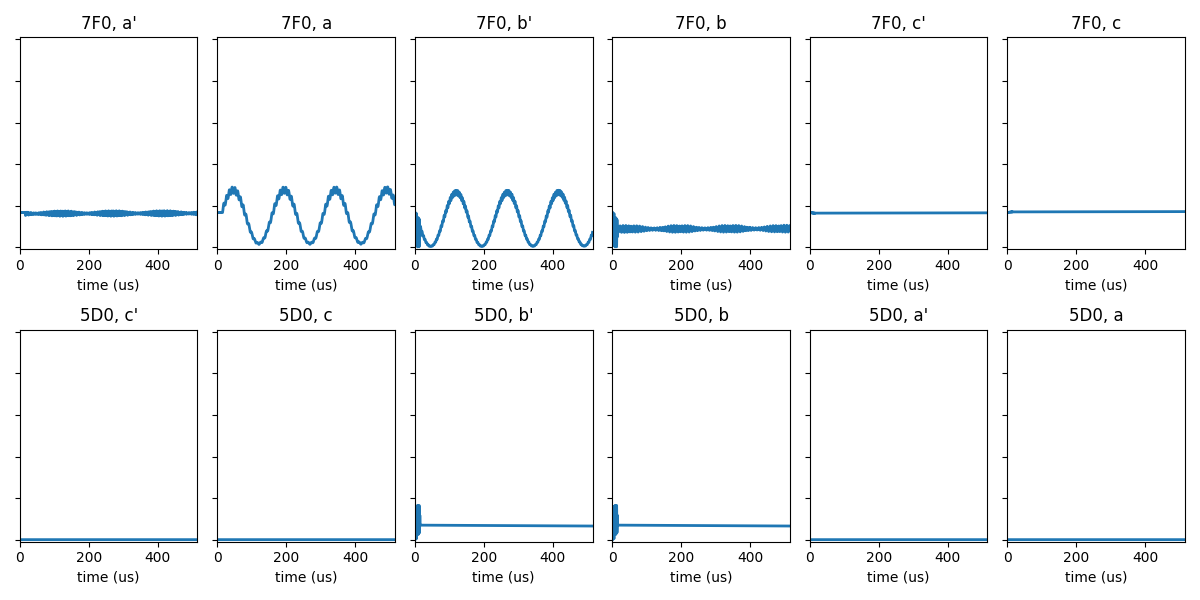

In [179]:
sequence = []

# OPTICAL PULSES ("optical"  , transition     , duration (us))
# RF PULSES      ("rf"       , offset (MHz)   , duration (us))
# DELAY          ("delay"    , duration (us)                 )

sequence.append(("optical", "bb", 15))
# sequence.append(("optical", "ac", 1.5))
# sequence.append(("optical", "ca", 1.5))
sequence.append(("rf", -0.24, 500))
# sequence.append(("delay", 50))
# sequence.append(("rf", -0.242, 1000))
# # sequence.append(("delay", 500))
# sequence.append(("rf", 0.1109, 500))

simulation = Simulation(sequence = sequence)
simulation.run_simulation()
simulation.plot_simulation()

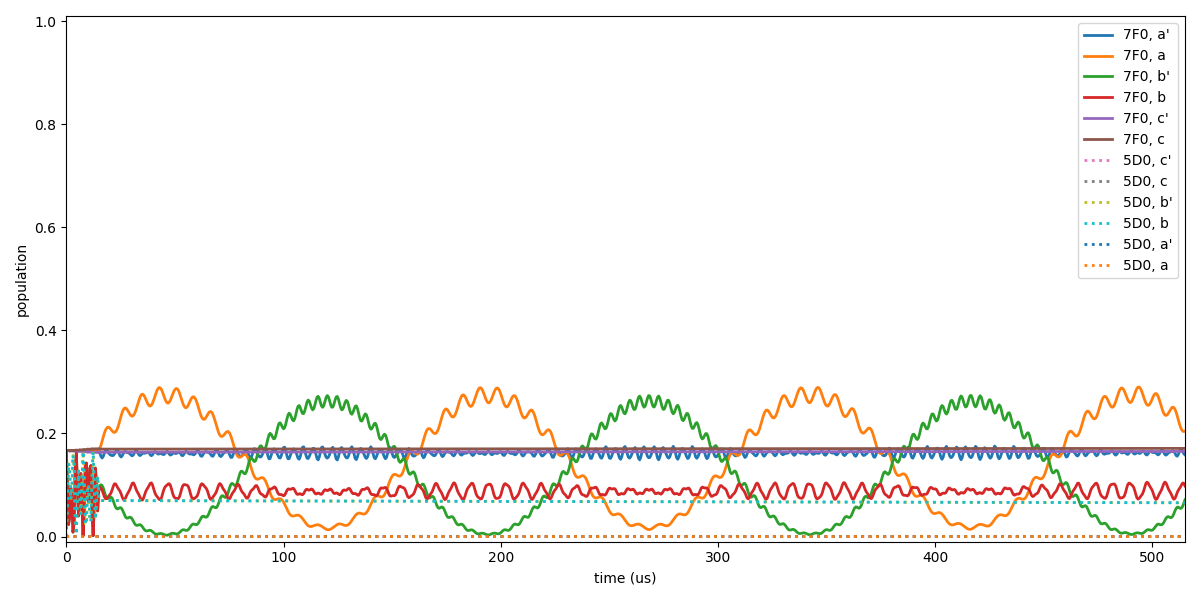

In [180]:
simulation.single_plot_simulation()

In [174]:
simulation.energies

{'7F0': {"a'": -202.8683560155122,
  'a': -202.64080442939627,
  "b'": -83.68367052510418,
  'b': -83.55737142030665,
  "c'": 6.357992366403029,
  'c': 6.392210023916319},
 '5D0': {"c'": -12.906969793922428,
  'c': -12.641003777188985,
  "b'": 181.19562484858034,
  'b': 181.35650486442165,
  "a'": 441.27755535285996,
  'a': 441.46828850525054}}

10.0%. Run time:   8.50s. Est. time left: 00:00:01:16
20.0%. Run time:  18.07s. Est. time left: 00:00:01:12
30.0%. Run time:  27.65s. Est. time left: 00:00:01:04
40.0%. Run time:  37.26s. Est. time left: 00:00:00:55
50.0%. Run time:  46.85s. Est. time left: 00:00:00:46
60.0%. Run time:  56.49s. Est. time left: 00:00:00:37
70.0%. Run time:  66.13s. Est. time left: 00:00:00:28
80.0%. Run time:  75.76s. Est. time left: 00:00:00:18
90.0%. Run time:  85.40s. Est. time left: 00:00:00:09
Total run time:  94.92s


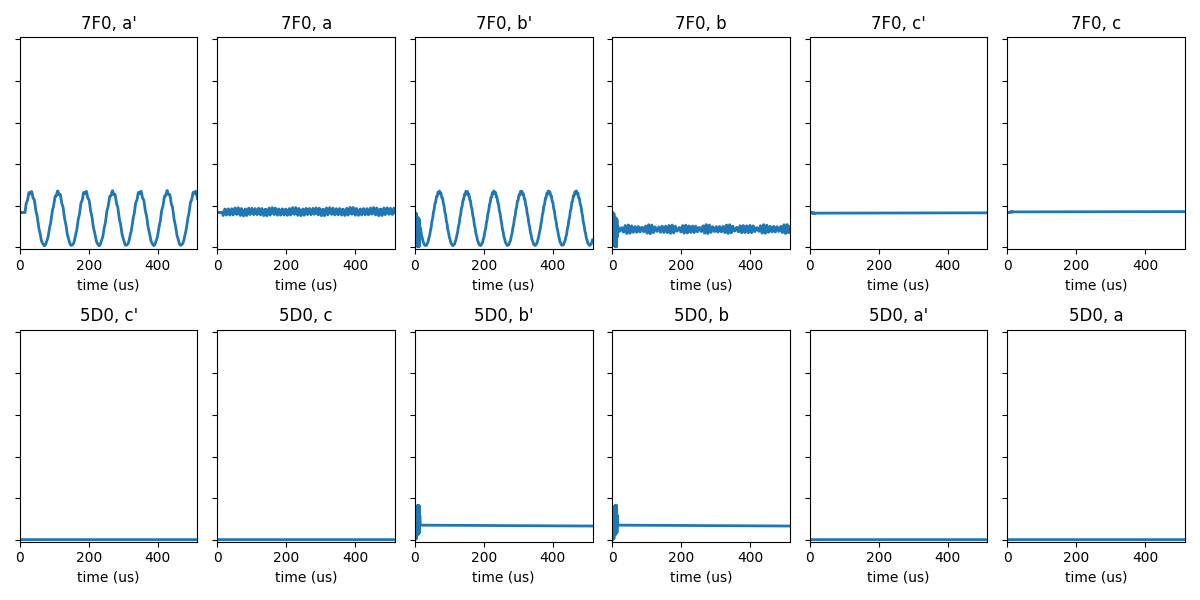

In [187]:
sequence = []

# OPTICAL PULSES ("optical"  , transition     , duration (us))
# RF PULSES      ("rf"       , offset (MHz)   , duration (us))
# DELAY          ("delay"    , duration (us)                 )

sequence.append(("optical", "bb", 15))
# sequence.append(("optical", "ac", 1.5))
# sequence.append(("optical", "ca", 1.5))
sequence.append(("rf", -0.015314509591974002, 500))
# sequence.append(("delay", 50))
# sequence.append(("rf", -0.242, 1000))
# # sequence.append(("delay", 500))
# sequence.append(("rf", 0.1109, 500))

simulation = Simulation(sequence = sequence)
simulation.run_simulation()
simulation.plot_simulation()

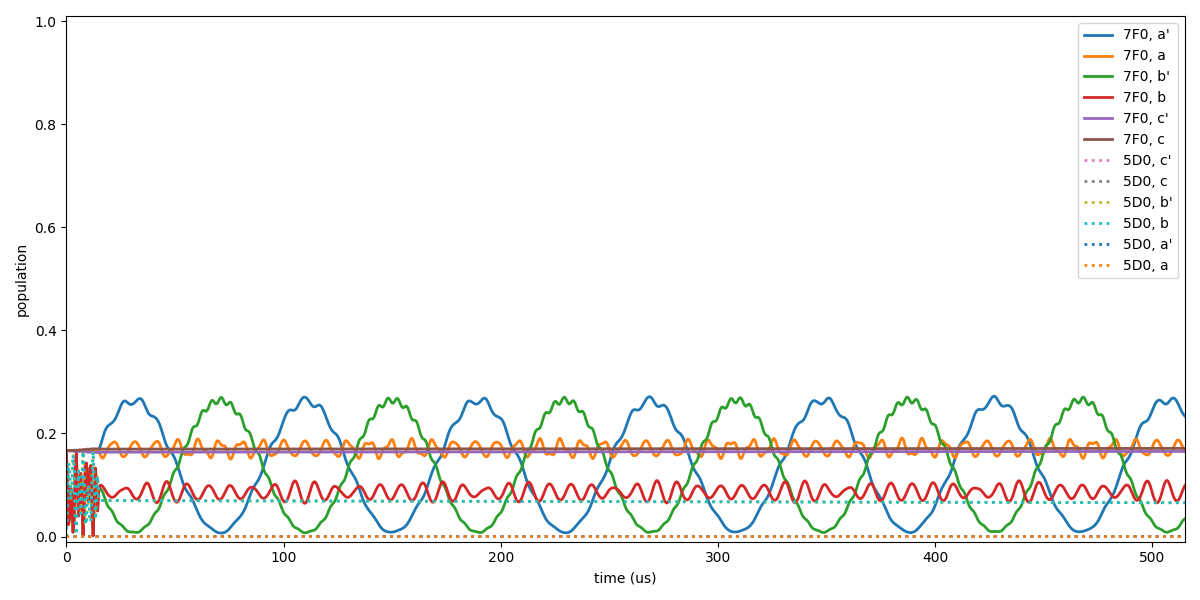

In [188]:
simulation.single_plot_simulation()

10.0%. Run time:  48.73s. Est. time left: 00:00:07:18
20.0%. Run time: 112.63s. Est. time left: 00:00:07:30
30.0%. Run time: 176.19s. Est. time left: 00:00:06:51
40.0%. Run time: 240.05s. Est. time left: 00:00:06:00
50.0%. Run time: 303.66s. Est. time left: 00:00:05:03
60.0%. Run time: 367.00s. Est. time left: 00:00:04:04
70.0%. Run time: 429.89s. Est. time left: 00:00:03:04
80.0%. Run time: 492.73s. Est. time left: 00:00:02:03
90.0%. Run time: 555.31s. Est. time left: 00:00:01:01
Total run time: 617.55s


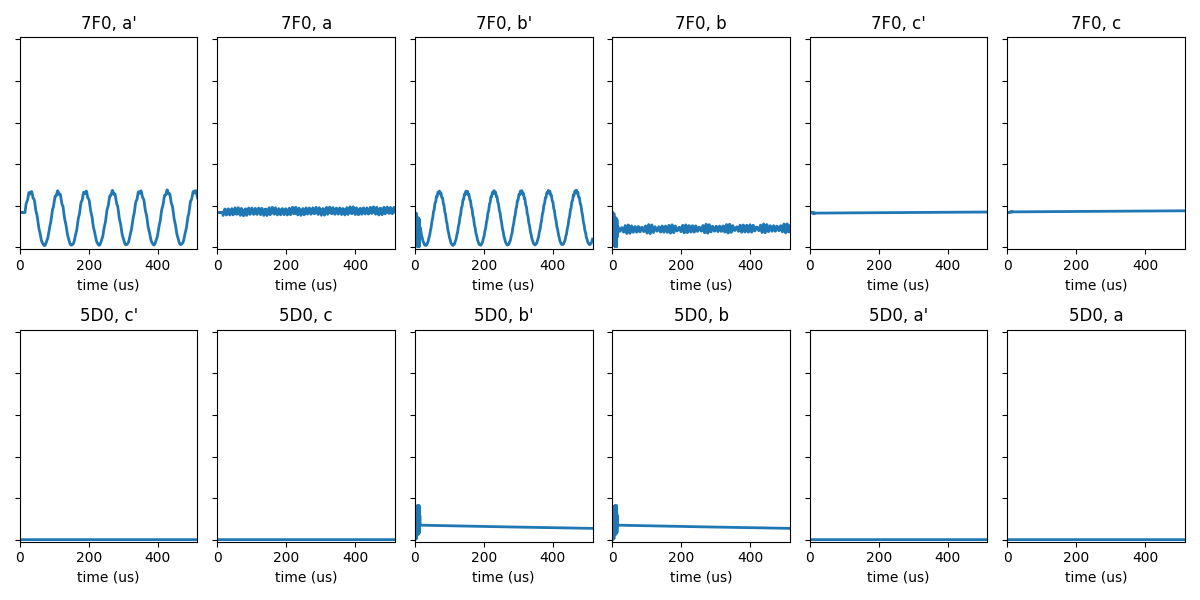

In [196]:
sequence = []

# OPTICAL PULSES ("optical"  , transition     , duration (us))
# RF PULSES      ("rf"       , offset (MHz)   , duration (us))
# DELAY          ("delay"    , duration (us)                 )

sequence.append(("optical", "bb", 15))
# sequence.append(("optical", "ac", 1.5))
# sequence.append(("optical", "ca", 1.5))
sequence.append(("rf", -0.015314509591974002, 500))
# sequence.append(("delay", 50))
# sequence.append(("rf", -0.242, 1000))
# # sequence.append(("delay", 500))
# sequence.append(("rf", 0.1109, 500))

simulation = Simulation(sequence = sequence)
simulation.run_simulation()
simulation.plot_simulation()

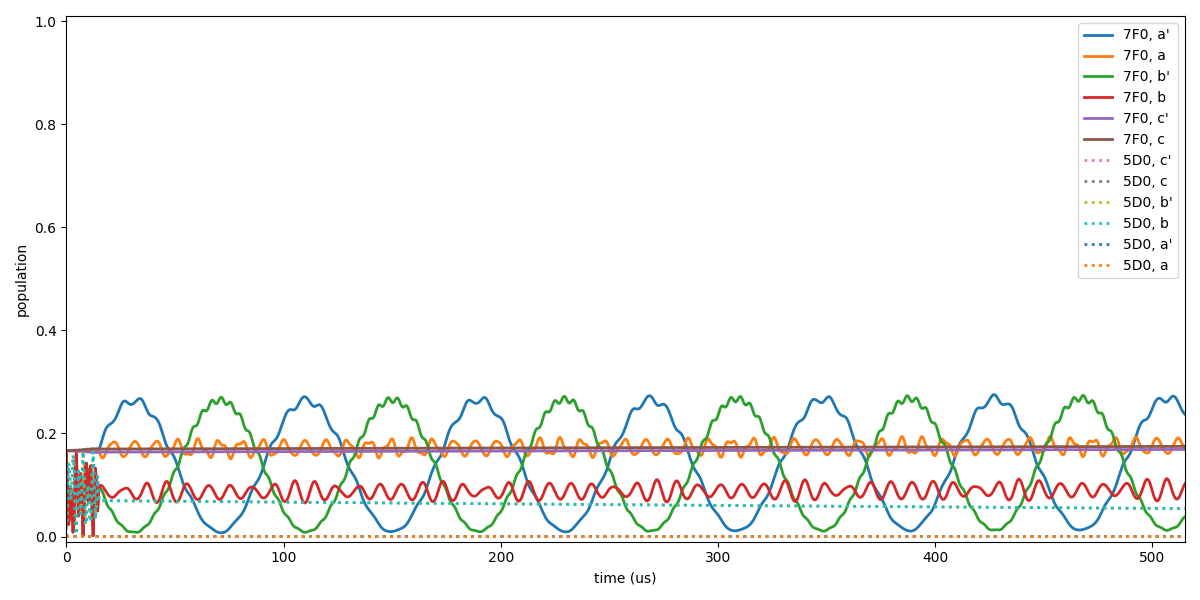

In [197]:
simulation.single_plot_simulation()

10.0%. Run time:  12.49s. Est. time left: 00:00:01:52
20.0%. Run time:  27.92s. Est. time left: 00:00:01:51
30.0%. Run time:  49.77s. Est. time left: 00:00:01:56
40.0%. Run time:  71.30s. Est. time left: 00:00:01:46
50.0%. Run time:  92.68s. Est. time left: 00:00:01:32
60.0%. Run time: 114.14s. Est. time left: 00:00:01:16
70.0%. Run time: 135.87s. Est. time left: 00:00:00:58
80.0%. Run time: 157.58s. Est. time left: 00:00:00:39
90.0%. Run time: 179.61s. Est. time left: 00:00:00:19
Total run time: 201.10s


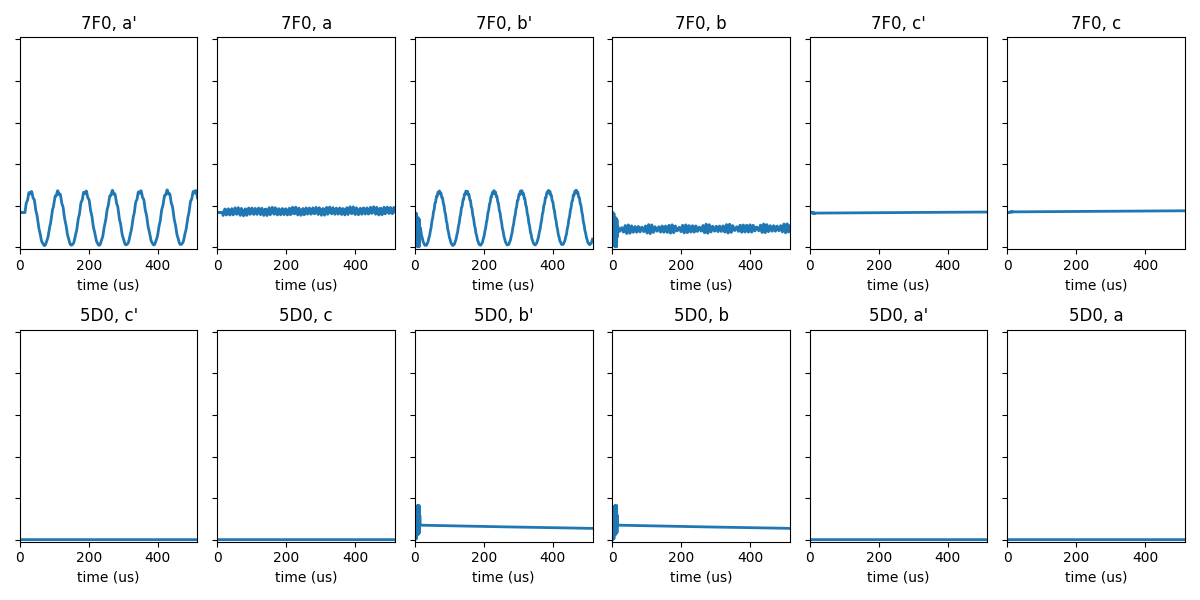

In [200]:
sequence = []

# OPTICAL PULSES ("optical"  , transition     , duration (us))
# RF PULSES      ("rf"       , offset (MHz)   , duration (us))
# DELAY          ("delay"    , duration (us)                 )

sequence.append(("optical", "bb", 15))
# sequence.append(("optical", "ac", 1.5))
# sequence.append(("optical", "ca", 1.5))
sequence.append(("rf", -0.015314509591974002, 500))
# sequence.append(("delay", 50))
# sequence.append(("rf", -0.242, 1000))
# # sequence.append(("delay", 500))
# sequence.append(("rf", 0.1109, 500))

simulation = Simulation(sequence = sequence)
simulation.run_simulation()
simulation.plot_simulation()

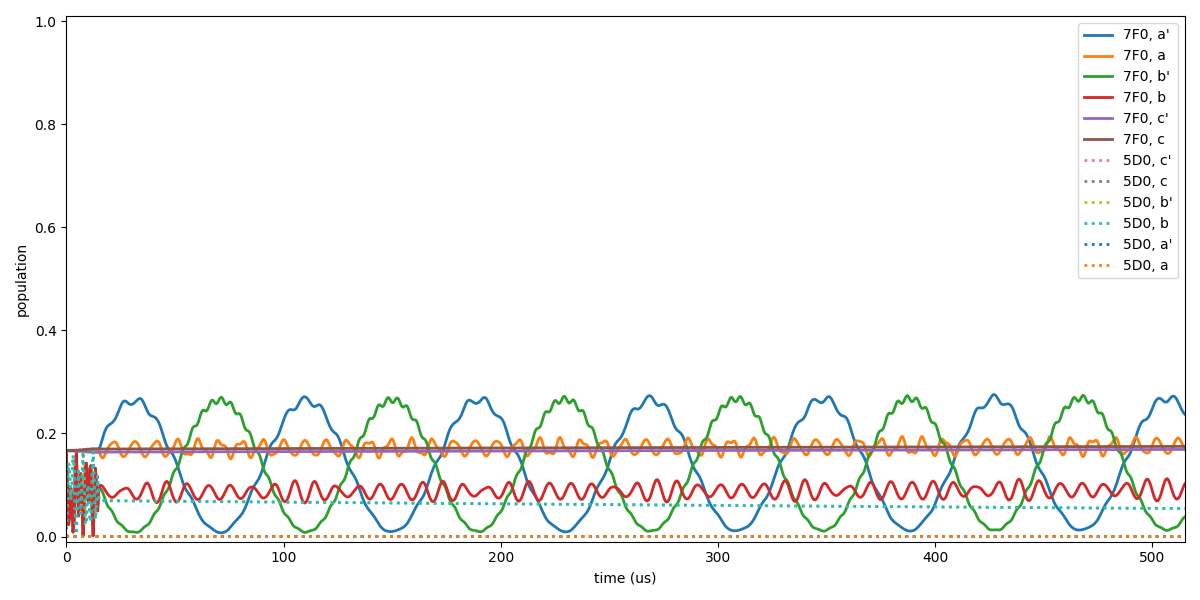

In [201]:
simulation.single_plot_simulation()

10.0%. Run time:   1.02s. Est. time left: 00:00:00:09
20.0%. Run time:   2.00s. Est. time left: 00:00:00:07
30.0%. Run time:   2.97s. Est. time left: 00:00:00:06
40.0%. Run time:   3.93s. Est. time left: 00:00:00:05
50.0%. Run time:   4.86s. Est. time left: 00:00:00:04
60.0%. Run time:   5.80s. Est. time left: 00:00:00:03
70.0%. Run time:   6.77s. Est. time left: 00:00:00:02
80.0%. Run time:   7.77s. Est. time left: 00:00:00:01
90.0%. Run time:   8.70s. Est. time left: 00:00:00:00
Total run time:   9.59s


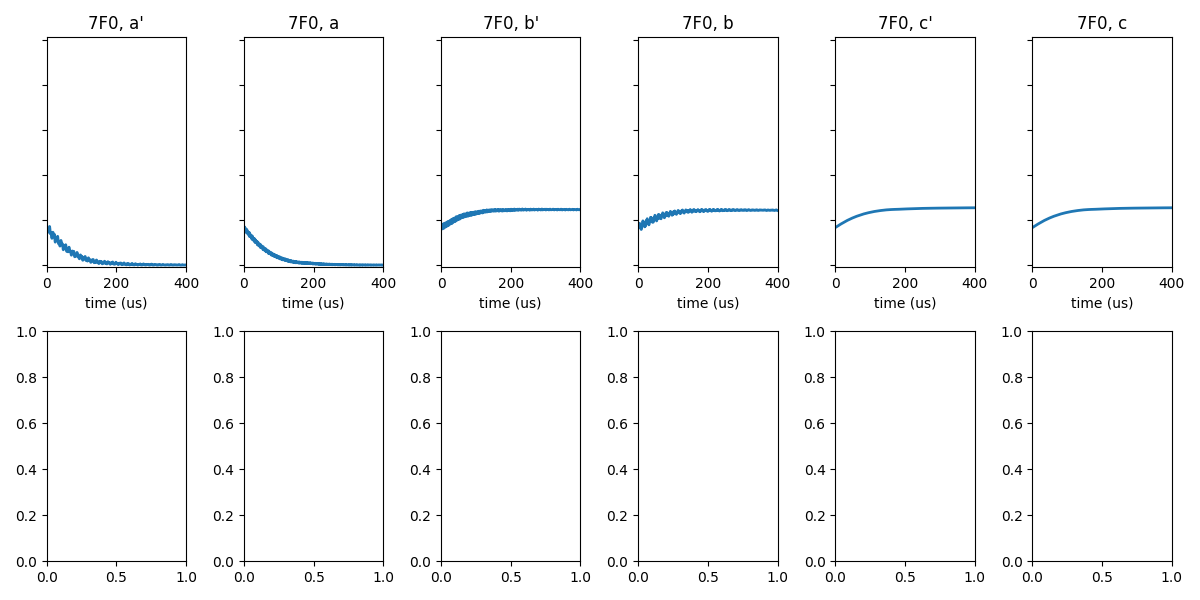

In [237]:
sequence = []

# OPTICAL PULSES ("optical"  , transition     , duration (us))
# RF PULSES      ("rf"       , offset (MHz)   , duration (us))
# DELAY          ("delay"    , duration (us)                 )

# sequence.append(("optical", "bb", 15))
# sequence.append(("optical", "ac", 1.5))
# sequence.append(("optical", "ca", 1.5))
sequence.append(("rf", 0.2, 400))
# sequence.append(("delay", 50))
# sequence.append(("rf", -0.242, 1000))
# # sequence.append(("delay", 500))
# sequence.append(("rf", 0.1109, 500))

simulation = Simulation(states_e = [], sequence = sequence)
simulation.run_simulation()
simulation.plot_simulation()

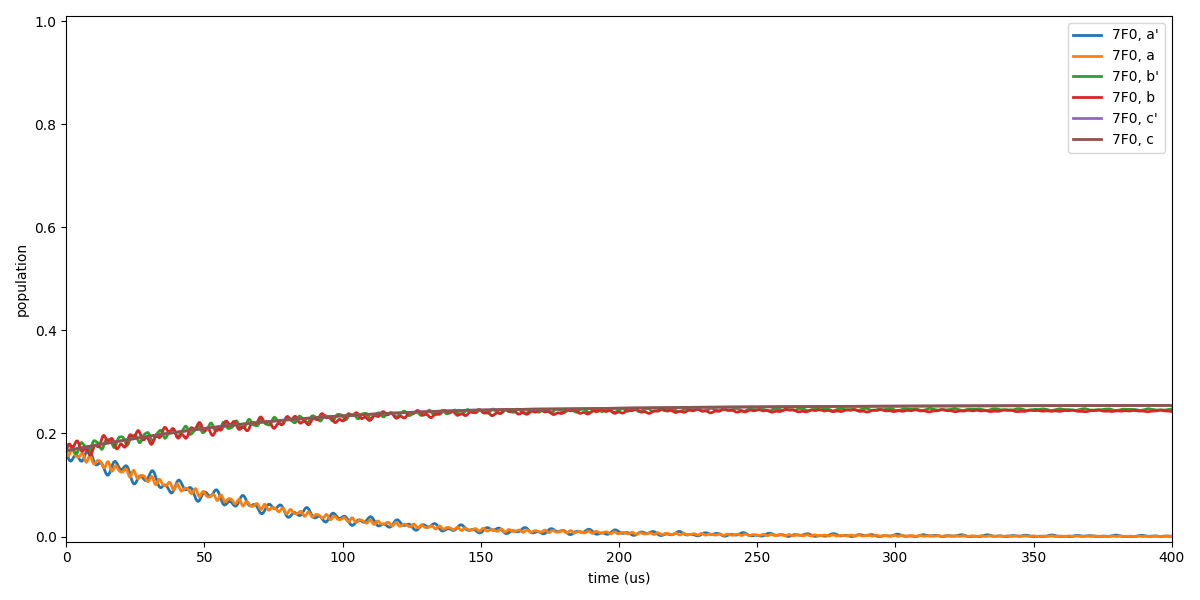

In [238]:
simulation.single_plot_simulation()

In [229]:
simulation.energies

{'7F0': {"a'": -202.8683560155122,
  'a': -202.64080442939627,
  "b'": -83.68367052510418,
  'b': -83.55737142030665,
  "c'": 6.357992366403029,
  'c': 6.392210023916319}}

In [230]:
simulation.e_ops

[Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = True
 Qobj data =
 [[1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]],
 Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = True
 Qobj data =
 [[0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]],
 Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = True
 Qobj data =
 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]],
 Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = True
 Qobj data =
 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]],
 Quantum object: dims = [[6], [6]], shape = (6, 6), type = oper, isherm = True
 Qobj data =
 [[0